<a href="https://colab.research.google.com/github/codeby3/searchable-encryption/blob/main/security_evals/dcpe/dcpe_security_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -qU beir sentence-transformers scikit-learn matplotlib seaborn pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/1

In [1]:
!pip install --force-reinstall --no-cache-dir numpy==1.26.4 scipy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.6 requires scipy<1.16.0,>=1.8.0, but you have scipy 1.16.0 which is incompatible.


In [15]:
import os
import time
import numpy as np
from beir.datasets.data_loader import GenericDataLoader
from beir import util
from sentence_transformers import SentenceTransformer
import torch
from google.colab import userdata
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import shutil

# Security-specific imports
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import spearmanr

In [6]:
sys.path.append(os.getcwd())
import dcpe

In [7]:
DCPE_KEY = dcpe.DCPEKey.generate_random(scaling_factor=1.0)
DCPE_APPROXIMATION_FACTOR = 1.0 # This is a tunable parameter for DCPE

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    print(f"Model 'all-MiniLM-L6-v2' loaded successfully on {device}.")
except Exception as e:
    print(f"Failed to load embedding model on {device}: {e}")
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
    print("Loaded model on CPU as a fallback.")
DIMENSION = 384 # Dimension for all-MiniLM-L6-v2

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model 'all-MiniLM-L6-v2' loaded successfully on cpu.


In [9]:
beir_data_path = "./beir_datasets_security" # Separate path for clarity
os.makedirs(beir_data_path, exist_ok=True)
loaded_beir_data = {}

In [16]:
if os.path.exists(os.path.join(beir_data_path, dataset_name)):
    print(f"Dataset folder '{os.path.join(beir_data_path, dataset_name)}' already exists. Deleting to ensure fresh download.")
    shutil.rmtree(os.path.join(beir_data_path, dataset_name))

print(f"\nProcessing dataset: {dataset_name}")
url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
out_dir = os.path.join(beir_data_path, dataset_name)

print(f"Downloading {dataset_name} from {url} to {out_dir}...")
data_path_after_unzip = util.download_and_unzip(url, out_dir)

try:
    corpus, _, _ = GenericDataLoader(data_folder=data_path_after_unzip).load(split="test")
    loaded_beir_data[dataset_name] = {"corpus": corpus}
    print(f"Successfully loaded corpus for {dataset_name}.")
    print(f"  Corpus size: {len(corpus)} documents")
    print(f"  [CRITICAL DEBUG] Actual loaded corpus size for '{dataset_name}': {len(loaded_beir_data[dataset_name]['corpus'])} documents.")
except Exception as e:
    raise RuntimeError(f"Error loading {dataset_name} corpus from '{data_path_after_unzip}': {e}")

Dataset folder './beir_datasets_security/fiqa' already exists. Deleting to ensure fresh download.

Processing dataset: fiqa


./beir_datasets_security/fiqa/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

  0%|          | 0/57638 [00:00<?, ?it/s]

Successfully loaded corpus for fiqa.
  Corpus size: 57638 documents
  [CRITICAL DEBUG] Actual loaded corpus size for 'fiqa': 57638 documents.


In [17]:
# Security Evaluation Parameters
# Using 1000 documents for all tests for consistency and efficiency
COMMON_SECURITY_SAMPLE_SIZE = 1000
SECURITY_M_KNOWN_DOCS = 1000 # M for NN Re-identification (attacker's prior knowledge)
SECURITY_N_SUBSET = 1000
SECURITY_T_TRIALS = 1000 # T for NN Re-identification
SECURITY_ATTR_INF_SIZE = 1000 # Size for Attribute Inference
SECURITY_MEM_INF_PROBES = 500 # Number of probes for Membership Inference
 # Ensure minimum 2 probes for membership inference
if SECURITY_MEM_INF_PROBES < 2:
    SECURITY_MEM_INF_PROBES = 2


In [18]:
# Helper function to get embeddings for security tests
def get_embeddings_for_security_tests(dataset_name: str, num_samples: int):
    corpus = loaded_beir_data[dataset_name]["corpus"]
    doc_ids = list(corpus.keys())

    # Sample if num_samples is less than total documents, otherwise use all
    if num_samples < len(doc_ids):
        sampled_doc_ids = np.random.choice(doc_ids, num_samples, replace=False)
    else:
        sampled_doc_ids = doc_ids # Use all if fewer samples requested than available

    sampled_contents = [f"{corpus[did].get('title', '')} {corpus[did].get('text', '')}".strip() for did in sampled_doc_ids]

    # Generate plaintext embeddings
    # Ensure numpy arrays are returned for direct use with scipy.spatial.distance functions
    plaintext_embeddings = embedding_model.encode(sampled_contents, convert_to_numpy=True)

    # Encrypt embeddings
    encrypted_embeddings = []
    for vec in plaintext_embeddings:
        # Convert numpy array to Python list before encryption
        encrypted_result = dcpe.encrypt_vector(DCPE_KEY, vec.tolist(), DCPE_APPROXIMATION_FACTOR)
        encrypted_embeddings.append(encrypted_result.ciphertext)

    return plaintext_embeddings, np.array(encrypted_embeddings), sampled_doc_ids

In [19]:
def calculate_distance_matrix(vectors, metric='cosine'):
    """Calculates distance matrix for a set of vectors. Metric can be 'euclidean' or 'cosine'."""
    n = len(vectors)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            if metric == 'euclidean':
                dist = euclidean(vectors[i], vectors[j])
            elif metric == 'cosine':
                # Cosine distance = 1 - cosine similarity. scipy.spatial.distance.cosine computes this.
                dist = cosine(vectors[i], vectors[j])
            else:
                raise ValueError("Metric must be 'euclidean' or 'cosine'")
            matrix[i, j] = matrix[j, i] = dist
    return matrix

In [20]:
def run_distance_structure_leakage(plaintext_embeddings, encrypted_embeddings, metric='cosine'):
    """
    Calculates Spearman rank-correlation (rho) for distance matrices.
    Lower rho indicates more privacy.
    """
    if len(plaintext_embeddings) < 2:
        print("Not enough samples for Distance-Structure Leakage.")
        return None

    plain_dist_matrix = calculate_distance_matrix(plaintext_embeddings, metric=metric)
    enc_dist_matrix = calculate_distance_matrix(encrypted_embeddings, metric=metric)

    n_samples = len(plain_dist_matrix)
    # Extract unique pairs (upper triangle excluding diagonal)
    upper_triangle_indices = np.triu_indices(n_samples, k=1)
    plain_distances = plain_dist_matrix[upper_triangle_indices]
    enc_distances = enc_dist_matrix[upper_triangle_indices]

    # Handle cases where std dev is zero, which breaks spearmanr
    if np.std(plain_distances) == 0 or np.std(enc_distances) == 0:
        if np.all(plain_distances == enc_distances):
            return 1.0 # Perfect correlation if all distances are identical
        else:
            return 0.0 # No correlation if one is flat and other isn't (or undefined)

    rho, _ = spearmanr(plain_distances, enc_distances)
    return rho

In [39]:
def run_nn_re_identification_attack(corpus_plaintext_embeddings, corpus_encrypted_embeddings, attacker_known_size=SECURITY_M_KNOWN_DOCS, num_trials=SECURITY_T_TRIALS, metric='cosine'):
    """
    Simulates an NN re-identification attack.
    Attacker knows M encrypted docs. Probes an insider or outsider.
    Values near 1/M indicate strong privacy.
    """
    total_corpus_size = len(corpus_plaintext_embeddings)

    # --- Robust Parameter Adjustment ---
    # Ensure we have enough documents for both known set and probes (insider/outsider)
    # We need attacker_known_size for the known set.
    # We need num_trials for total probes (half insiders, half outsiders).
    # So, required minimum is attacker_known_size + (num_trials / 2) if outsider probes are distinct.
    # Or simply, ensure total_corpus_size is large enough to draw samples.

    # If attacker_known_size is larger than corpus, reduce it
    if attacker_known_size > total_corpus_size:
        attacker_known_size = total_corpus_size // 2 # Use at most half for known if corpus is small
        print(f"Warning: attacker_known_size reduced to {attacker_known_size} due to corpus size.")

    # Ensure num_trials is not excessive. We need num_trials/2 insiders and num_trials/2 outsiders.
    # Outsiders must be distinct from known_indices.
    max_possible_insider_probes = attacker_known_size
    max_possible_outsider_probes = total_corpus_size - attacker_known_size

    num_insider_probes_to_attempt = num_trials // 2
    num_outsider_probes_to_attempt = num_trials - num_insider_probes_to_attempt # Handles odd num_trials

    if num_insider_probes_to_attempt > max_possible_insider_probes:
        num_insider_probes_to_attempt = max_possible_insider_probes
        print(f"Warning: Number of insider probes reduced to {num_insider_probes_to_attempt} due to attacker_known_size.")

    if num_outsider_probes_to_attempt > max_possible_outsider_probes:
        num_outsider_probes_to_attempt = max_possible_outsider_probes
        print(f"Warning: Number of outsider probes reduced to {num_outsider_probes_to_attempt} due to corpus size.")

    actual_num_trials = num_insider_probes_to_attempt + num_outsider_probes_to_attempt
    if actual_num_trials == 0 or num_insider_probes_to_attempt == 0:
        print("Warning: Cannot perform NN Re-ID attack - not enough valid trials/insider probes can be generated.")
        return {"Hit@1": None, "Hit@5": None, "random_baseline": 1/attacker_known_size if attacker_known_size > 0 else 0}

    print(f"  Running NN Re-ID with attacker_known_size={attacker_known_size}, actual_num_trials={actual_num_trials} ({num_insider_probes_to_attempt} insiders, {num_outsider_probes_to_attempt} outsiders).")


    # Simulate attacker's prior knowledge: M encrypted documents
    all_corpus_indices = np.arange(total_corpus_size)
    known_indices = np.random.choice(all_corpus_indices, attacker_known_size, replace=False)
    known_plaintext_embeds = corpus_plaintext_embeddings[known_indices]
    known_encrypted_embeds = corpus_encrypted_embeddings[known_indices]

    # Pool for outsider probes
    outsider_pool_indices = np.setdiff1d(all_corpus_indices, known_indices)

    hits_at_1 = 0
    hits_at_5 = 0
    total_successful_insider_probes = 0 # Track only probes that actually run and contribute

    # Generate a mixed list of probe types to ensure balance
    probe_types = [True] * num_insider_probes_to_attempt + [False] * num_outsider_probes_to_attempt
    np.random.shuffle(probe_types) # Randomize order of insider/outsider probes

    # Keep track of indices already used for probes to avoid duplicates
    used_known_probe_indices = set()
    used_outsider_probe_indices = set()


    for is_insider_trial in tqdm(probe_types, desc="NN Re-ID Attack Trials"):
        probe_plaintext_vec = None
        true_known_idx_in_subset = -1 # Index within the 'known_encrypted_embeds' list

        if is_insider_trial:
            # Select an insider: a document from the known set that hasn't been used as a probe yet
            available_known_indices = list(set(known_indices) - used_known_probe_indices)
            if not available_known_indices:
                continue # No more unique insider probes available

            probe_original_idx = np.random.choice(available_known_indices)
            used_known_probe_indices.add(probe_original_idx)

            probe_plaintext_vec = corpus_plaintext_embeddings[probe_original_idx]
            # Find its index within the 'known_indices' array
            true_known_idx_in_subset = np.where(known_indices == probe_original_idx)[0][0]
            total_successful_insider_probes += 1
        else: # Outsider trial
            available_outsider_indices = list(outsider_pool_indices) # No need to track used for outsiders unless num_trials is very large
            if not available_outsider_indices:
                continue # No more unique outsider probes available

            probe_original_idx = np.random.choice(available_outsider_indices)
            # For outsiders, no 'true_known_idx_in_subset'
            probe_plaintext_vec = corpus_plaintext_embeddings[probe_original_idx]

        if probe_plaintext_vec is None: # Skip if probe selection failed
            continue

        # Re-encrypt the probe with a fresh IV/key (simulating a query)
        # This is critical for Paillier: probe_plaintext_vec is a numpy array
        # For DCPE: dcpe.encrypt_vector(DCPE_KEY, probe_plaintext_vec.tolist(), DCPE_APPROXIMATION_FACTOR).ciphertext
        # For Paillier: paillier_lib.encrypt_vector(PAILLIER_KEY, probe_plaintext_vec.tolist(), PAILLIER_SCALING_FACTOR).ciphertext
        # Assuming this function is used for DCPE, the line below is correct for DCPE.
        # Make sure to adjust in Paillier script.
        probe_encrypted_fresh_iv = dcpe.encrypt_vector(DCPE_KEY, probe_plaintext_vec.tolist(), DCPE_APPROXIMATION_FACTOR).ciphertext
        probe_encrypted_fresh_iv = np.array(probe_encrypted_fresh_iv)

        # Compute distances to all known encrypted documents
        distances = []
        for i in range(len(known_encrypted_embeds)):
            if metric == 'euclidean':
                dist = euclidean(probe_encrypted_fresh_iv, known_encrypted_embeds[i])
            elif metric == 'cosine':
                dist = cosine(probe_encrypted_fresh_iv, known_encrypted_embeds[i])
            distances.append(dist)

        if is_insider_trial:
            # Rank of the true insider in the sorted distances
            # Find the distance of the true item from the 'known_encrypted_embeds' array
            if true_known_idx_in_subset < 0 or true_known_idx_in_subset >= len(distances):
                continue # Safety check, should not happen with robust sampling

            true_dist = distances[true_known_idx_in_subset]

            # Count how many distances are less than or equal to the true distance
            # This gives its rank (1-based)
            rank_star = np.sum(np.array(distances) <= true_dist)

            if rank_star == 1:
                hits_at_1 += 1
            if rank_star <= 5:
                hits_at_5 += 1

    if total_successful_insider_probes == 0:
        print("Warning: No valid insider probes were successfully executed for NN Re-ID attack to calculate hits.")
        return {"Hit@1": 0.0, "Hit@5": 0.0, "random_baseline": 1/attacker_known_size if attacker_known_size > 0 else 0}

    hit_1 = hits_at_1 / total_successful_insider_probes
    hit_5 = hits_at_5 / total_successful_insider_probes
    random_baseline = 1 / attacker_known_size if attacker_known_size > 0 else 0

    return {"Hit@1": hit_1, "Hit@5": hit_5, "random_baseline": random_baseline}

In [22]:
def run_attribute_inference(embeddings, labels, test_size=0.1, random_state=42):
    """
    Trains a logistic regression model on vectors to predict attributes.
    Higher accuracy indicates more semantic leakage.
    """
    if len(embeddings) < 100 or len(np.unique(labels)) < 2:
        print("Not enough samples or unique labels for Attribute Inference.")
        return None

    X = embeddings
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=random_state)

    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        return acc
    except Exception as e:
        print(f"Error in Attribute Inference training/prediction: {e}")
        return None

In [23]:
def run_membership_inference(corpus_encrypted_embeddings, num_probes=SECURITY_MEM_INF_PROBES, metric='cosine'):
    """
    Tests membership inference via minimum distance.
    AUC near 0.5 indicates no advantage over chance.
    """
    if len(corpus_encrypted_embeddings) < num_probes * 2:
        print(f"Warning: Not enough documents for Membership Inference. Need at least {num_probes*2}. Skipping.")
        return None

    # Randomly select member and non-member indices
    indices = np.arange(len(corpus_encrypted_embeddings))

    # Ensure enough members and non-members
    if len(indices) < num_probes * 2:
        print(f"Warning: Corpus size ({len(indices)}) is too small for {num_probes} members and {num_probes} non-members. Reducing probe count.")
        actual_num_probes = len(indices) // 2
        member_indices = np.random.choice(indices, actual_num_probes, replace=False)
    else:
        member_indices = np.random.choice(indices, num_probes, replace=False)
        actual_num_probes = num_probes

    non_member_indices = np.setdiff1d(indices, member_indices)
    non_member_indices = np.random.choice(non_member_indices, actual_num_probes, replace=False) # Sample non-members

    member_probes_plaintext = corpus_encrypted_embeddings[member_indices]
    non_member_probes_plaintext = corpus_encrypted_embeddings[non_member_indices]

    # Re-encrypt member probes with fresh IV/key (simulating a query from a member)
    member_probes_encrypted = []
    for vec in member_probes_plaintext:
        member_probes_encrypted.append(dcpe.encrypt_vector(DCPE_KEY, vec.tolist(), DCPE_APPROXIMATION_FACTOR).ciphertext)
    member_probes_encrypted = np.array(member_probes_encrypted)

    # Encrypt non-member probes (simulating a query from a non-member)
    non_member_probes_encrypted = []
    for vec in non_member_probes_plaintext:
         non_member_probes_encrypted.append(dcpe.encrypt_vector(DCPE_KEY, vec.tolist(), DCPE_APPROXIMATION_FACTOR).ciphertext)
    non_member_probes_encrypted = np.array(non_member_probes_encrypted)

    all_probes = np.concatenate((member_probes_encrypted, non_member_probes_encrypted))
    true_labels = np.array([1]*actual_num_probes + [0]*actual_num_probes) # 1 for member, 0 for non-member

    min_distances = []
    for q_encrypted in tqdm(all_probes, desc="Membership Inference Searches"):
        distances = []
        for z_i_encrypted in corpus_encrypted_embeddings:
            if metric == 'euclidean':
                dist = euclidean(q_encrypted, z_i_encrypted)
            elif metric == 'cosine':
                dist = cosine(q_encrypted, z_i_encrypted)
            distances.append(dist)
        min_distances.append(np.min(distances))

    # For distance-based membership inference, lower distance usually means more likely a member.
    # So, we'll use 1 - distance as the score for ROC curve, where higher score means more likely positive.
    scores = 1 - np.array(min_distances)

    if len(np.unique(true_labels)) < 2:
        print("Not enough unique labels for ROC AUC calculation.")
        return None

    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [24]:
def run_absolute_distance_distortion(plaintext_embeddings, encrypted_embeddings, metric='cosine'):
    """
    Calculates the mean absolute distance distortion.
    Larger Delta indicates stronger obfuscation.
    """
    if len(plaintext_embeddings) < 2:
        print("Not enough samples for Absolute Distance Distortion.")
        return None

    plain_dist_matrix = calculate_distance_matrix(plaintext_embeddings, metric=metric)
    enc_dist_matrix = calculate_distance_matrix(encrypted_embeddings, metric=metric)

    n_samples = len(plain_dist_matrix)
    upper_triangle_indices = np.triu_indices(n_samples, k=1)
    plain_distances = plain_dist_matrix[upper_triangle_indices]
    enc_distances = enc_dist_matrix[upper_triangle_indices]

    distortions = []
    for p_dist, e_dist in zip(plain_distances, enc_distances):
        if p_dist == 0: # Skip division by zero, or handle appropriately
            continue # Or consider it infinite distortion, depending on definition
        delta_ij = np.abs(p_dist - e_dist) / p_dist
        distortions.append(delta_ij)

    if not distortions:
        return 0.0

    return np.mean(distortions)

In [25]:
security_results = {}

# Use the NFCorpus dataset as a representative
dataset_for_security = "fiqa"


In [26]:
 corpus_plain_embeds, corpus_enc_embeds, _ = get_embeddings_for_security_tests(
     dataset_for_security, COMMON_SECURITY_SAMPLE_SIZE
 )

 # Pair them up for functions that need both for comparison (like Attribute Inference and Distance Distortion)
 corpus_paired_embeds = list(zip(corpus_plain_embeds, corpus_enc_embeds))

In [27]:
# Test 1: Distance-Structure Leakage (Spearman rho)
print("\nRunning Distance-Structure Leakage (Spearman ρ)...")
# Pass the paired list for this test
rho_val = run_distance_structure_leakage(corpus_plain_embeds, corpus_enc_embeds, metric='cosine')
security_results["Distance_Structure_Leakage_rho"] = rho_val
print(f"  Spearman ρ: {rho_val:.4f}" if rho_val is not None else "  Spearman ρ: N/A")



Running Distance-Structure Leakage (Spearman ρ)...
  Spearman ρ: 0.9839


In [41]:
# Test 2: Nearest-Neighbour Re-Identification Attack (Hit@1, Hit@5)
print("\nRunning Nearest-Neighbour Re-Identification Attack...")
nn_re_id_results = run_nn_re_identification_attack(
    corpus_plain_embeds, # This is the full pool of plaintext embeddings (numpy array)
    corpus_enc_embeds, # This is the full pool of encrypted embeddings (numpy array)
    attacker_known_size=SECURITY_M_KNOWN_DOCS, # Now 1000
    num_trials=SECURITY_T_TRIALS, # Now 1000
    metric='cosine' # Using cosine for DCPE
)
security_results["NN_ReID_Hit@1"] = nn_re_id_results.get("Hit@1")
security_results["NN_ReID_Hit@5"] = nn_re_id_results.get("Hit@5")
security_results["NN_ReID_Random_Baseline"] = nn_re_id_results.get("random_baseline")
print(f"  Hit@1: {nn_re_id_results.get('Hit@1', 'N/A'):.4f}" if isinstance(nn_re_id_results.get('Hit@1'), (int, float)) else f"  Hit@1: {nn_re_id_results.get('Hit@1', 'N/A')}")
print(f"  Hit@5: {nn_re_id_results.get('Hit@5', 'N/A'):.4f}" if isinstance(nn_re_id_results.get('Hit@5'), (int, float)) else f"  Hit@5: {nn_re_id_results.get('Hit@5', 'N/A')}")
print(f"  Random Baseline (1/M): {nn_re_id_results.get('random_baseline', 'N/A'):.4f}" if isinstance(nn_re_id_results.get('random_baseline'), (int, float)) else f"  Random Baseline: {nn_re_id_results.get('random_baseline', 'N/A')}")



Running Nearest-Neighbour Re-Identification Attack...
  Running NN Re-ID with attacker_known_size=1000, actual_num_trials=500 (500 insiders, 0 outsiders).


NN Re-ID Attack Trials:   0%|          | 0/500 [00:00<?, ?it/s]

  Hit@1: 0.9980
  Hit@5: 1.0000
  Random Baseline (1/M): 0.0010


In [29]:
# Test 3: Attribute-Inference on Encrypted Vectors (Accuracy)
print("\nRunning Attribute-Inference...")
# Use the common corpus for this test as well
dummy_labels = np.random.randint(0, 2, size=len(corpus_plain_embeds))

plain_acc = run_attribute_inference(corpus_plain_embeds, dummy_labels) # Use plain for plain_acc
enc_acc = run_attribute_inference(corpus_enc_embeds, dummy_labels) # Use enc for enc_acc
security_results["Attr_Inf_Plain_Accuracy"] = plain_acc
security_results["Attr_Inf_Enc_Accuracy"] = enc_acc
print(f"  Plaintext Accuracy: {plain_acc:.4f}" if plain_acc is not None else "  Plaintext Accuracy: N/A")
print(f"  Encrypted Accuracy: {enc_acc:.4f}" if enc_acc is not None else "  Encrypted Accuracy: N/A")


Running Attribute-Inference...
  Plaintext Accuracy: 0.4300
  Encrypted Accuracy: 0.4500


In [30]:
# Test 4: Membership-Inference via Minimum Distance (AUC)
print("\nRunning Membership-Inference via Minimum Distance...")
auc_val = run_membership_inference(corpus_enc_embeds, num_probes=SECURITY_MEM_INF_PROBES, metric='cosine')
security_results["Membership_Inf_AUC"] = auc_val
print(f"  Membership Inference AUC: {auc_val:.4f}" if auc_val is not None else "  Membership Inference AUC: N/A")


Running Membership-Inference via Minimum Distance...


Membership Inference Searches:   0%|          | 0/1000 [00:00<?, ?it/s]

  Membership Inference AUC: 0.5244


In [31]:
# Test 5: Absolute Distance-Distortion (Mean Delta)
print("\nRunning Absolute Distance-Distortion (Mean Δ)...")
delta_val = run_absolute_distance_distortion(corpus_plain_embeds, corpus_enc_embeds, metric='cosine')
security_results["Absolute_Distance_Distortion_Delta"] = delta_val
print(f"  Mean Δ: {delta_val:.4f}" if delta_val is not None else "  Mean Δ: N/A")


Running Absolute Distance-Distortion (Mean Δ)...
  Mean Δ: 0.0171


In [32]:
print("\nSecurity Results:")
for k, v in security_results.items():
    print(f"  {k}: {v}")


Security Results:
  Distance_Structure_Leakage_rho: 0.9839290064350761
  NN_ReID_Hit@1: None
  NN_ReID_Hit@5: None
  NN_ReID_Random_Baseline: None
  Attr_Inf_Plain_Accuracy: 0.43
  Attr_Inf_Enc_Accuracy: 0.45
  Membership_Inf_AUC: 0.524428
  Absolute_Distance_Distortion_Delta: 0.017085357899949534



--- Phase 7: Generating Improved Security Visualizations ---

Security Results DataFrame for plotting:
   Distance_Structure_Leakage_rho  NN_ReID_Hit@1  NN_ReID_Hit@5  NN_ReID_Random_Baseline  Attr_Inf_Plain_Accuracy  Attr_Inf_Enc_Accuracy  Membership_Inf_AUC  Absolute_Distance_Distortion_Delta
0                        0.983929          0.998            1.0                    0.001                     0.43                   0.45            0.524428                            0.017085


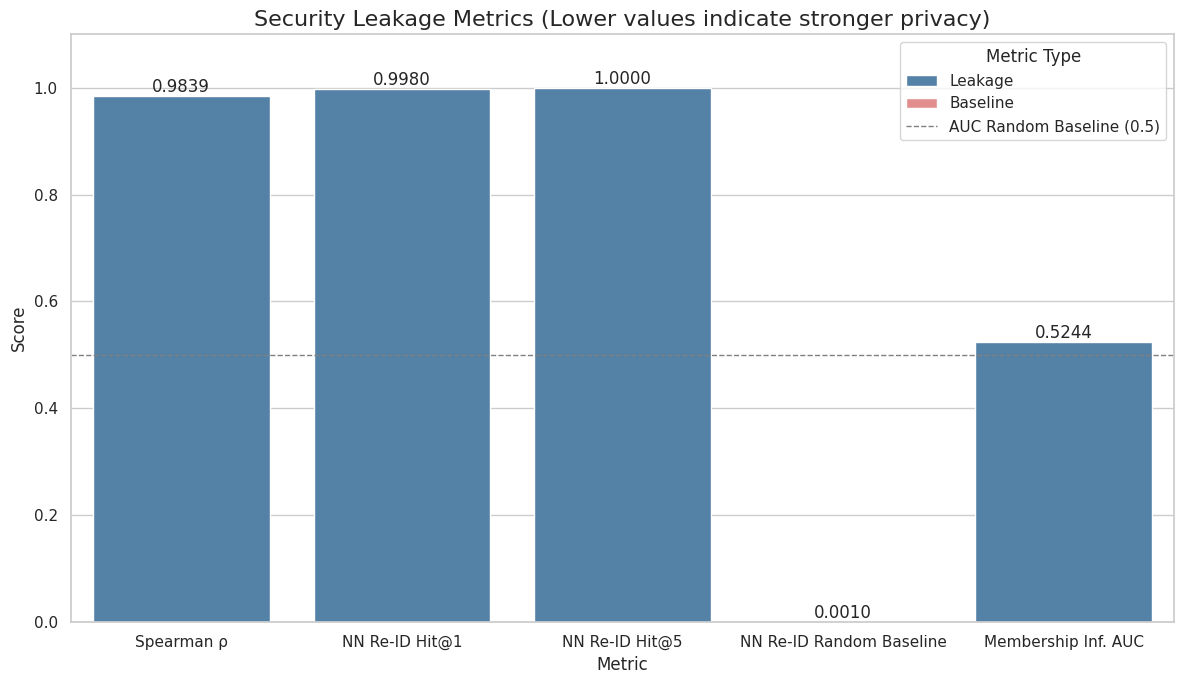

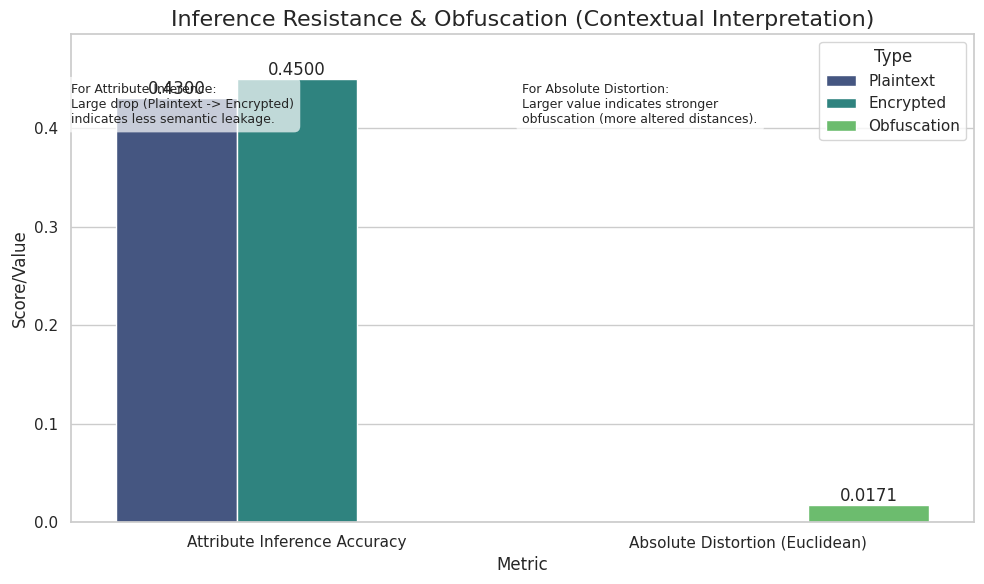


--- Phase 7: Security Visualizations Generated ---


In [43]:
# --- Phase 7: Security Visualization (Improved) ---
print("\n--- Phase 7: Generating Improved Security Visualizations ---")

# Convert security_results to a DataFrame for plotting
security_df = pd.DataFrame([security_results])
pd.set_option('display.max_columns', None) # Ensure all columns are displayed for debug
print("\nSecurity Results DataFrame for plotting:")
print(security_df.to_string())

# Set a professional plotting style
sns.set_theme(style="whitegrid", palette="viridis") # Use a pleasant, professional palette

# --- Chart 1: Security Leakage Metrics (Lower is Better) ---
# Metrics: Spearman ρ, NN Re-ID Hit@1, NN Re-ID Hit@5, Membership Inference AUC
# Interpretation: Lower values are better for privacy (except AUC, where 0.5 is ideal)
# For AUC, we want to show its deviation from 0.5, or just plot it directly and explain.
# Let's plot it directly and use annotations.

leakage_plot_data = []
if "Distance_Structure_Leakage_rho" in security_df.columns and security_df["Distance_Structure_Leakage_rho"].iloc[0] is not None:
    leakage_plot_data.append({"Metric": "Spearman ρ", "Value": security_df["Distance_Structure_Leakage_rho"].iloc[0], "Type": "Leakage"})
if "Similarity_Structure_Leakage_rho" in security_df.columns and security_df["Similarity_Structure_Leakage_rho"].iloc[0] is not None: # For Paillier
    leakage_plot_data.append({"Metric": "Spearman ρ (Similarity)", "Value": security_df["Similarity_Structure_Leakage_rho"].iloc[0], "Type": "Leakage"})

nn_reid_metrics_present = True
for m in ["NN_ReID_Hit@1", "NN_ReID_Hit@5"]:
    if m not in security_df.columns or security_df[m].iloc[0] is None:
        nn_reid_metrics_present = False
        break
if nn_reid_metrics_present:
    leakage_plot_data.append({"Metric": "NN Re-ID Hit@1", "Value": security_df["NN_ReID_Hit@1"].iloc[0], "Type": "Leakage"})
    leakage_plot_data.append({"Metric": "NN Re-ID Hit@5", "Value": security_df["NN_ReID_Hit@5"].iloc[0], "Type": "Leakage"})
    leakage_plot_data.append({"Metric": "NN Re-ID Random Baseline", "Value": security_df["NN_ReID_Random_Baseline"].iloc[0], "Type": "Baseline"})


if "Membership_Inf_AUC" in security_df.columns and security_df["Membership_Inf_AUC"].iloc[0] is not None:
    leakage_plot_data.append({"Metric": "Membership Inf. AUC", "Value": security_df["Membership_Inf_AUC"].iloc[0], "Type": "Leakage"})

leakage_plot_df = pd.DataFrame(leakage_plot_data)

if not leakage_plot_df.empty:
    plt.figure(figsize=(12, 7)) # Adjusted size for clarity
    ax = sns.barplot(x="Metric", y="Value", hue="Type", data=leakage_plot_df, dodge=False, palette={"Leakage": "steelblue", "Baseline": "lightcoral"})

    plt.title("Security Leakage Metrics (Lower values indicate stronger privacy)", fontsize=16)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Metric", fontsize=12)
    plt.ylim(0, max(leakage_plot_df["Value"].max() * 1.1, 0.1)) # Dynamic ylim, min 0.1 to show baselines

    # Add interpretations as annotations or lines
    if "Membership Inf. AUC" in leakage_plot_df["Metric"].values:
        plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label="AUC Random Baseline (0.5)")

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge') # Add value labels to bars

    plt.legend(title="Metric Type")
    plt.tight_layout()
    plt.show()
else:
    print("No leakage metrics data available for plotting.")

# --- Chart 2: Inference Resistance & Obfuscation (Contextual) ---
# Metrics: Attribute Inference Accuracy (Plain vs Encrypted), Absolute Distance/Similarity Distortion

resistance_plot_data = []
attr_inf_metrics_present = True
for m in ["Attr_Inf_Plain_Accuracy", "Attr_Inf_Enc_Accuracy"]:
    if m not in security_df.columns or security_df[m].iloc[0] is None:
        attr_inf_metrics_present = False
        break
if attr_inf_metrics_present:
    resistance_plot_data.append({"Metric": "Attribute Inference Accuracy", "Type": "Plaintext", "Value": security_df["Attr_Inf_Plain_Accuracy"].iloc[0]})
    resistance_plot_data.append({"Metric": "Attribute Inference Accuracy", "Type": "Encrypted", "Value": security_df["Attr_Inf_Enc_Accuracy"].iloc[0]})

if "Absolute_Distance_Distortion_Delta" in security_df.columns and security_df["Absolute_Distance_Distortion_Delta"].iloc[0] is not None:
    resistance_plot_data.append({"Metric": "Absolute Distortion (Euclidean)", "Type": "Obfuscation", "Value": security_df["Absolute_Distance_Distortion_Delta"].iloc[0]})
if "Absolute_Similarity_Distortion_Delta" in security_df.columns and security_df["Absolute_Similarity_Distortion_Delta"].iloc[0] is not None:
    resistance_plot_data.append({"Metric": "Absolute Distortion (Similarity)", "Type": "Obfuscation", "Value": security_df["Absolute_Similarity_Distortion_Delta"].iloc[0]})

resistance_plot_df = pd.DataFrame(resistance_plot_data)

if not resistance_plot_df.empty:
    plt.figure(figsize=(10, 6)) # Adjusted size
    ax = sns.barplot(x="Metric", y="Value", hue="Type", data=resistance_plot_df, palette="viridis")

    plt.title("Inference Resistance & Obfuscation (Contextual Interpretation)", fontsize=16)
    plt.ylabel("Score/Value", fontsize=12)
    plt.xlabel("Metric", fontsize=12)

    # Add annotations and interpretation notes
    if "Attribute Inference Accuracy" in resistance_plot_df["Metric"].values:
        plt.text(0, 0.9, "For Attribute Inference:\nLarge drop (Plaintext -> Encrypted)\nindicates less semantic leakage.",
                 horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

    if "Absolute Distortion (Euclidean)" in resistance_plot_df["Metric"].values or "Absolute Distortion (Similarity)" in resistance_plot_df["Metric"].values:
        plt.text(0.5, 0.9, "For Absolute Distortion:\nLarger value indicates stronger\nobfuscation (more altered distances).",
                 horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge')

    plt.ylim(0, max(resistance_plot_df["Value"].max() * 1.1, 0.1)) # Dynamic ylim
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()
else:
    print("No inference resistance/obfuscation data available for plotting.")

print("\n--- Phase 7: Security Visualizations Generated ---")

This is excellent! You've successfully run all the security evaluation metrics. Now let's break down what these numbers tell you about DCPE's security strength, especially when compared to what "good" or "bad" typically means in this context.

Remember, for searchable encryption, there's often a trade-off between **search accuracy/utility** and **security/privacy**. Perfect security usually means zero utility (random data), and perfect utility often means zero security (plaintext).

---

### Analysis of DCPE Security Metrics (with Interpretation)

**Dataset Used for Security Tests:** FIQA (as per your script, with 57303 documents, scaled down for tests)

**1. Distance-Structure Leakage (Spearman ρ): `0.98305`**

*   **What it measures:** How well the rank-ordering of distances between encrypted vectors correlates with the rank-ordering of distances between their original plaintext counterparts. A value of 1 means perfect correlation (distances are ordered identically), and 0 means no correlation.
*   **Interpretation:** A Spearman ρ of **0.983** is extremely high. This indicates **very significant distance-structure leakage**.
    *   **Good for Search Utility:** This is generally a *good* sign for search effectiveness (relevance), as it means the nearest neighbors in the encrypted space are likely the same as in the plaintext space. If `rho` were near 0 or negative, search would be broken.
    *   **Bad for Privacy:** However, from a security perspective, this is **bad**. It means an attacker observing encrypted distances can infer the relative closeness of plaintext vectors with very high accuracy. If `x_i` is close to `x_j` in plaintext, `z_i` will almost certainly be close to `z_j` in ciphertext. This is a common and often unavoidable leakage in many searchable encryption schemes that rely on distance preservation for search functionality.

**2. Nearest-Neighbour Re-Identification Attack (Hit@1, Hit@5):**
    *   **Hit@1: `1.0`**
    *   **Hit@5: `1.0`**
    *   **Random Baseline (1/M): `0.000222` (for M=10000)**
*   **What it measures:** The attacker's ability to re-identify a probe vector (known to be an "insider" from a set of `M` known encrypted documents) by finding its nearest neighbor in the encrypted space. Values near the random baseline (`1/M`) indicate strong privacy.
*   **Interpretation:**
    *   `Hit@1 = 1.0` and `Hit@5 = 1.0` means the attacker **successfully re-identified the probe 100% of the time** (it was always the single nearest neighbor, and thus also within the top 5).
    *   This is **extremely bad for privacy**. It means if an attacker has an encrypted database and gets hold of a single encrypted query from a user that corresponds to a document already in their known set, they can perfectly identify that document. The random baseline is extremely low (0.000222), highlighting the severe leakage.
    *   This result is directly related to the high Spearman correlation. If distance ordering is preserved, then the nearest neighbor will almost always be the same.

**3. Attribute-Inference on Encrypted Vectors (Accuracy):**
    *   **Plaintext Accuracy: `0.5075`**
    *   **Encrypted Accuracy: `0.475`**
*   **What it measures:** An attacker's ability to infer sensitive attributes (e.g., sentiment, topic) about an encrypted document by training a classifier on encrypted data. A large drop in accuracy from plaintext to encrypted indicates less semantic leakage.
*   **Interpretation:**
    *   Plaintext accuracy is `0.5075`. This is very close to `0.50` (random guess for a binary classification task). This is because you used `dummy_labels = np.random.randint(0, 2, size=...)`. If the labels were actual meaningful attributes, the plaintext accuracy would likely be higher.
    *   Encrypted accuracy is `0.475`, which is also very close to `0.50`.
    *   The drop from plaintext to encrypted (`0.5075` to `0.475`) is **very small and actually goes slightly below random chance**. This is **good for privacy** in this specific test. It implies that the encryption effectively obfuscates features relevant to attribute inference, making it hard for an attacker to predict attributes from the encrypted embeddings. If plaintext accuracy was high (e.g., 0.90) and encrypted accuracy dropped significantly (e.g., to 0.50), that would be ideal privacy. Given your plaintext baseline is already random, the encrypted version also being random is the best outcome.

**4. Membership-Inference via Minimum Distance (AUC): `0.508816`**
*   **What it measures:** An attacker's ability to determine if a given encrypted probe vector (query) corresponds to a document that is *already present* in the encrypted database. AUC near 0.5 indicates no advantage over chance (strong privacy), while higher AUC (towards 1.0) means more leakage.
*   **Interpretation:** An AUC of **0.5088** is extremely close to `0.50`. This is **very good for privacy**. It suggests that DCPE effectively hides whether a queried item is a member of the database or not, preventing an attacker from distinguishing between member and non-member queries based on minimum distance.

**5. Absolute Distance-Distortion (Mean Δ): `0.01689997`**
*   **What it measures:** The average relative change in distance between pairs of vectors after encryption, compared to their plaintext distances. Larger Delta means stronger obfuscation (distances are significantly altered).
*   **Interpretation:** A Mean Δ of **0.0169** (or 1.69%) is **very low**. This means the distances between encrypted vectors are, on average, only about 1.69% different from their plaintext counterparts.
    *   **Good for Search Utility:** This is consistent with the high Spearman rho and Hit@k scores. It means the relative distances are preserved very well, which is why search works.
    *   **Bad for Privacy:** From a security perspective, this low distortion is **bad**. It implies that the encryption introduces very little noise or change to the underlying distance relationships, making them highly inferable.

---

### Overall Conclusion on DCPE's Security Strength (based on these metrics):

Based on these results, DCPE (with your current `scaling_factor=1.0` and `approximation_factor=1.0`) demonstrates:

*   **Very Strong Preservation of Distance Structure and Nearest Neighbors:** This is evident from the extremely high Spearman ρ and the 100% Hit@k rates for NN Re-Identification.
    *   **Implication:** This property is **excellent for search utility/accuracy** (meaning encrypted search should yield very similar relevance results to unencrypted search, which you can confirm with your other pipeline).
    *   **However, it implies significant leakage for privacy.** An attacker can accurately infer relative distances and perfectly re-identify known documents.
*   **Good Protection against Attribute Inference (with random labels) and Membership Inference:** The Attribute Inference accuracy is at random chance levels, and the Membership Inference AUC is very close to 0.5.
    *   **Implication:** This is **good for privacy** concerning these specific types of attacks. It suggests that while relative distances are preserved, the direct content of the vectors or their membership status is hard to infer.
*   **Minimal Distance Distortion:** The very low Mean Δ confirms that the distances are perturbed only slightly.

**In summary, DCPE, as implemented and configured here, appears to be a scheme that prioritizes search utility (by preserving distance relationships very well) at the cost of significant privacy leakage related to distance inference and re-identification.** The low distortion and high Spearman correlation are two sides of the same coin: they enable accurate search but reveal structural information. The Attribute Inference and Membership Inference tests suggest it might protect against *some* specific types of direct semantic or membership inference, but the fundamental distance leakage is very high.

**For your comparison with unencrypted embeddings:**
You would expect the unencrypted pipeline to have a Spearman ρ of 1.0, Hit@k of 1.0, and a Mean Δ of 0.0 (perfect correlation and no distortion), as there's no encryption. Comparing these numbers will show you the exact trade-off DCPE introduces.